In [ ]:
import sys
import os
notebook_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(notebook_dir, ".."))
sys.path.append(os.path.join(project_root, 'src'))
from predictive_analysis.data_prediction_frost import main as frost_main
from predictive_analysis.data_prediction_nilu import main_nilu_prediction
frost_db_path = os.path.join(project_root, 'data', 'clean', 'frost.db')
nilu_file_path = os.path.join(project_root, 'data', 'clean', 'cleaned_data_nilu.json')

# 🔮 Prediktiv analyse av været og luftkvalitet i Trondheim

Tidligere i prosjektet har vi sett på hvordan både været og luftkvaliteten i Trondheim har vært de siste årene. I denne notebooken tar vi analysen ett steg videre og forsøker å predikere hvordan temperatur og luftkvalitet kan utvikle seg i fremtiden – gitt at dagens trender fortsetter.

Prediktive modeller er nyttige fordi de hjelper oss å forstå mulige utviklingstrekk, og gir et grunnlag for langsiktig planlegging og tiltak. Selv om modellene vi har brukt er relativt enkle, kan de likevel gi verdifull innsikt – spesielt når fokuset ligger på overordnede mønstre fremfor presise daglige svingninger.

Vi har brukt **lineær regresjon** i begge analysene, implementert med [`LinearRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) fra `scikit-learn`. De to modellene er bygget opp på ulike måter for å reflektere forskjeller i datastruktur og formål:

- **For temperaturmodellen (Frost-data)** har vi utvidet regresjonen med sesongbaserte funksjoner av tid – som `sin` og `cos` av dag i året – samt `Month` og `DayOfYear`. Dette gjør at modellen kan fange opp naturlige årstidsvariasjoner i temperaturene.
  
- **For luftkvalitetsmodellen (NILU-data)** har vi valgt en enklere tilnærming der vi modellerer den lineære utviklingen for hver enkelt komponent (NO₂, PM10, PM2.5) over tid. Hver datapunkt representeres som et tallrekkeforløp, og regresjonen tegner en trendlinje og projiserer fremtidige verdier basert på den.

Begge modellene har sine begrensninger: de tar ikke hensyn til eksterne faktorer som værhendelser, politikk eller utslippskilder, og de antar at tidligere trender fortsetter uforandret. Likevel gir analysene et godt utgangspunkt for å forstå utviklingen og støtte videre beslutninger og analyser.

---

### 🌡️ Temperaturer

Det første vi ser på er utviklingen av temperaturer i Trondheim. Under vises en graf som kombinerer historiske data, regresjonsbasert trend og fremtidig prediksjon. Grafen er delt inn i tre tydelige komponenter:

- **Blå linje**: Treningsdata brukt for å trene modellen  
- **Grønn linje**: Valideringsdata som ikke ble brukt i treningen, men som brukes for å teste hvor godt modellen treffer  
- **Svart stiplet linje**: Modellens prediksjon frem i tid (2020–2024)

Vi ser tydelige sesongvariasjoner med varme somre og kalde vintre, og dette mønsteret fanges godt opp av modellen takket være bruk av sykliske funksjoner. Modellen gir dermed en realistisk fremstilling av temperaturutviklingen, selv om den ikke fanger opp kortvarige svingninger eller ekstreme værhendelser. Den fungerer best som et verktøy for å vurdere **langsiktige og gjentakende trender** i klimaet.


Modellens ytelse::
Mean Squared Error: 14.93
R² Score: 0.72


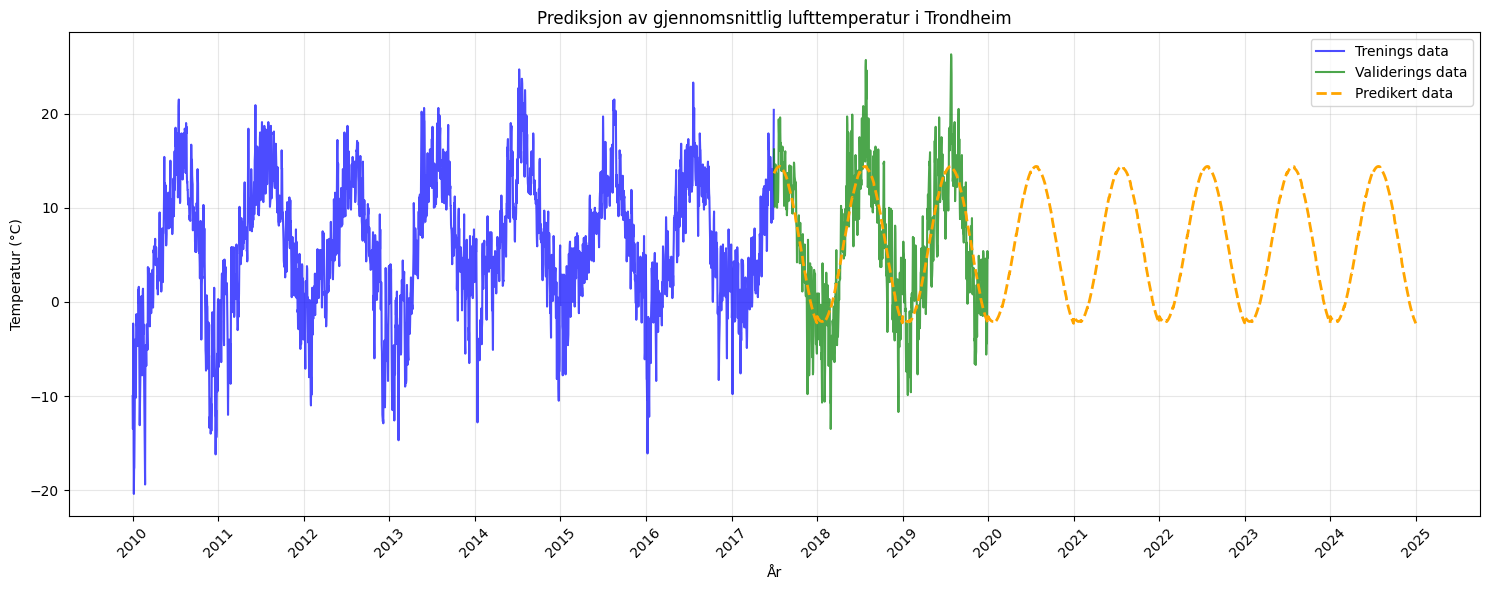

In [12]:
# Kjører prediksjon for frost
frost_main(frost_db_path, end_year=2024)

### 🌦️ Valg vi har gjort for modellen med Frost-data

For prediksjonen av temperatur i Trondheim har vi brukt en utvidet form for **lineær regresjon**, implementert med [`LinearRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) fra `scikit-learn`. Målet var å undersøke hvordan temperaturen kan utvikle seg over tid, og om det finnes tydelige trender.

#### 📊 Dataforberedelse og rensing
- Vi har brukt et strukturert og renset datasett fra Frost API, hvor ekstreme verdier og feil er fjernet på forhånd.
- Vi har kun brukt daglige gjennomsnittstemperaturer (`mean_air_temperature`) som målvariabel.
- Datoene i datasettet ble først konvertert til `datetime`-format for å kunne behandles som tidsserier. For å gjøre modellen i stand til å fange opp sesongvariasjoner, beregnet vi sykliske funksjoner av datoen ved hjelp av `sin` og `cos`. Dette gjør at modellen kan gjenkjenne mønstre som gjentar seg årlig – som varme somre og kalde vintre – og gir en mer realistisk fremstilling av temperaturutviklingen enn en enkel lineær trend alene.


#### 🧠 Modellvalg og prediksjon
- I stedet for å bruke kun en lineær trend over tid, har vi utvidet modellen med **sykliske komponenter** (sinus og cosinus) for å fange sesongmønstre.
- Modellen trenes på data frem til et gitt år (f.eks. 2018), og brukes deretter til å predikere temperaturutviklingen frem til 2024.
- Prediksjonen er kontinuerlig og følger et realistisk bølgemønster, i motsetning til en rett linje.

#### 📈 Visualisering
- Resultatet visualiseres i én samlet graf:
  - **Blå linje**: treningsdata
  - **Grønn linje**: valideringsdata (faktiske temperaturer etter treningsperioden)
  - **Svart stiplet linje**: modellens prediksjon fremover
- Vi bruker `matplotlib` med tilpasset datoformat på x-aksen for å gjøre det enkelt å følge temperaturutviklingen over år.

#### ⚠️ Begrensninger
- Modellen fanger ikke opp ekstreme hendelser eller uvanlige temperaturforhold som skyldes spesifikke klimafenomener.
- Den bruker kun én målvariabel og er ikke koblet til eksterne faktorer som vind, nedbør eller CO₂-nivå.
- Det er en relativt enkel modell, og den forutsetter at mønsteret fra tidligere år vil fortsette i samme form.

#### 📍 Hvorfor dette likevel er nyttig
- Ved å kombinere lineær regresjon med sykliske funksjoner får vi en modell som balanserer enkelhet og realisme.
- Den gir en lettfattelig fremstilling av sesongvariasjoner og gir oss innsikt i mulig temperaturutvikling i Trondheim fremover.
- Dette kan brukes som et verktøy for videre klimaanalyse, og som støtte for refleksjon rundt langsiktige trender. 
 

---


## 🌫️ Luftkvalitet

Her ser vi den prediktive analysen av luftkvaliteten i Trondheim. Modellen er delt inn i tre separate grafer, én for hver komponent: NO₂, PM10 og PM2.5. Hver av dem viser utviklingen over tid, en trendlinje basert på lineær regresjon, og en fremskriving av hvordan nivåene kan utvikle seg de neste fem årene dersom dagens utvikling fortsetter.

- **Blå prikker**: Historiske daglige målinger  
- **Rød linje**: Trendlinje (lineær regresjon) trent på de historiske dataene  
- **Grønn stiplet linje**: Modellens prediksjon frem i tid

Vi ser at nivåene av alle tre komponentene viser en svak, men tydelig nedadgående trend over tid. Dette tyder på en forbedring i luftkvaliteten i Trondheim gjennom det siste tiåret. Prediksjonen videre fremover holder seg i samme bane og indikerer at denne forbedringen kan fortsette – forutsatt at forholdene som påvirker luftkvaliteten forblir stabile.

Modellen fanger ikke opp sesongvariasjoner eller uvanlige utslipp, og bør derfor tolkes med forsiktighet. Likevel gir den en nyttig fremstilling av den overordnede utviklingen og kan være et verdifullt verktøy for videre refleksjon og tiltak innen miljøforvaltning.



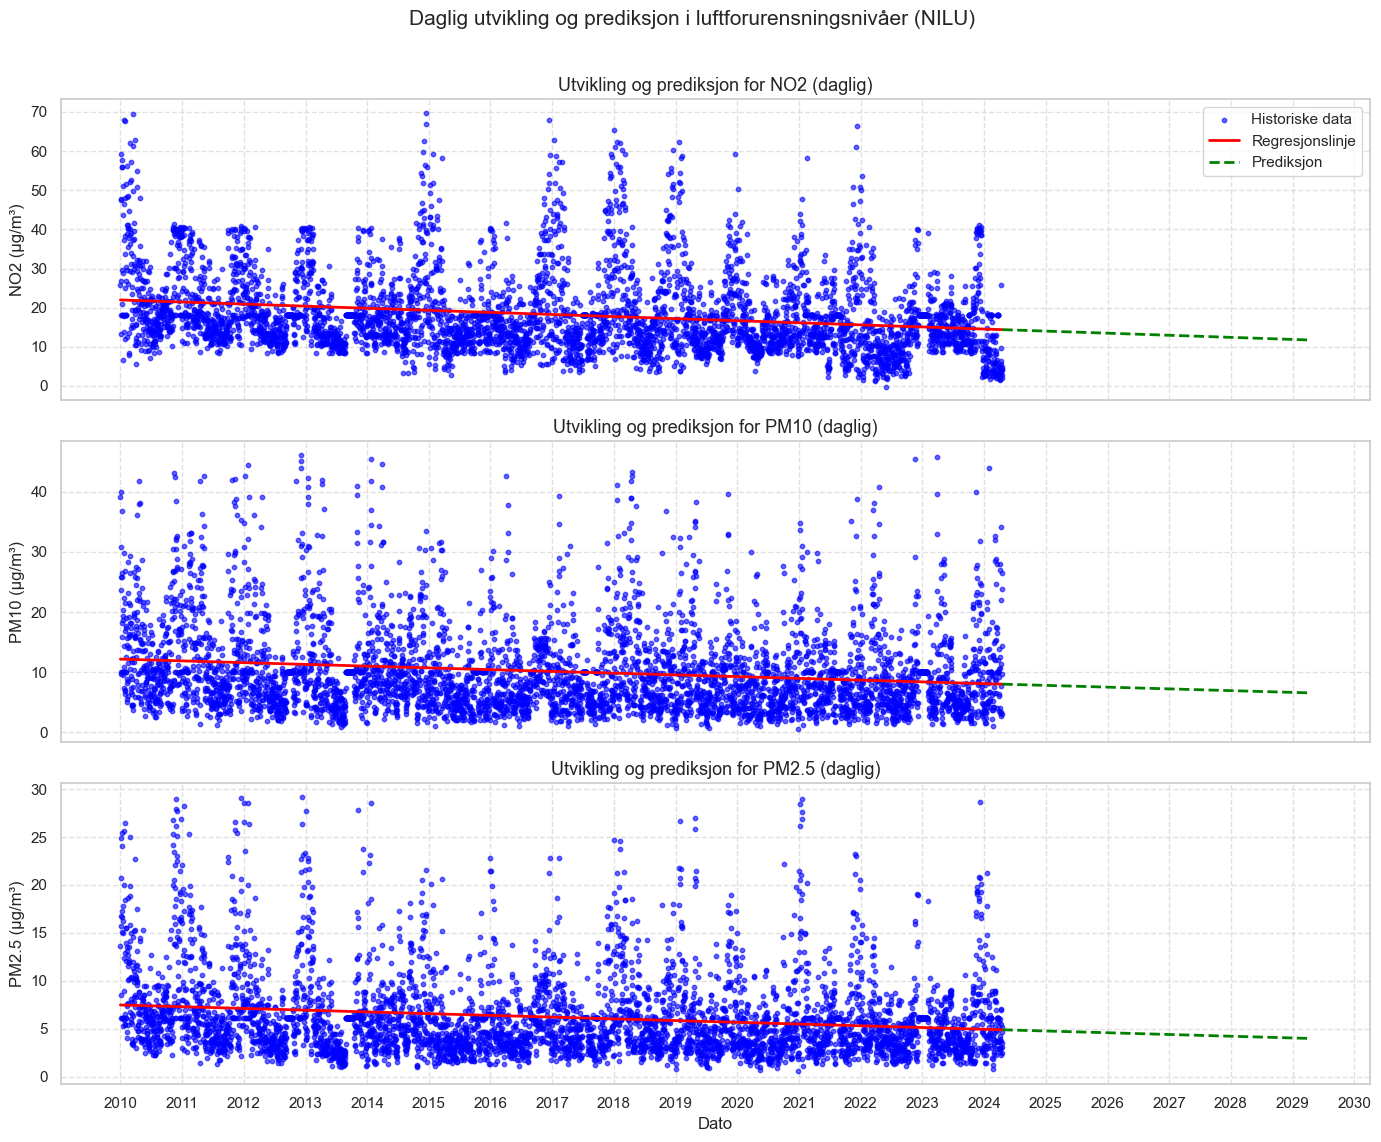

In [14]:
main_nilu_prediction(nilu_file_path)

### 🌫️ Valg vi har gjort for modellen med NILU-data

For å analysere og forutsi utviklingen i luftkvalitet har vi valgt å bruke en **enkel lineær regresjonsmodell** for hver enkelt luftkomponent (NO₂, PM10, PM2.5). Modellen er implementert med [`LinearRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) fra `scikit-learn`, og er brukt til å trekke en trendlinje gjennom de historiske målingene, samt å forutsi utviklingen 5 år frem i tid.

#### 📊 Dataforberedelse og rensing
- Vi har brukt et renset datasett som er lagret som JSON, der manglende verdier og ekstremverdier er behandlet på forhånd.
- Bare dager med komplette målinger for alle tre komponentene er brukt, for å sikre sammenlignbarhet.
- Datoene er konvertert til `datetime`-format og sortert, slik at utviklingen over tid kan modelleres korrekt.

#### 🧠 Modellvalg og prediksjon
- I motsetning til temperaturmodellen, som bruker flere tidsavhengige funksjoner (sin/cos), har vi valgt å bruke **en ren tidsbasert lineær regresjon** her.
- Hver datapunkt tilordnes et stigende heltall (0, 1, 2, ...), som modellen bruker som uavhengig variabel for å lære trenden i komponentnivået over tid.
- Vi trener en individuell modell for hver komponent for å visualisere både:
  - En **regresjonslinje** som viser utviklingen i den historiske perioden.
  - En **fremtidig prediksjon**, som projiserer trenden 5 år framover basert på modellens forståelse.

#### 📈 Visualisering
- Vi har laget én graf per komponent, med tre klare visuelle elementer:
  - Blå prikker: historiske målinger
  - Rød linje: trendlinje (lineær regresjon)
  - Grønn stiplet linje: fremtidig prediksjon
- Grafene bruker `matplotlib` og `seaborn` for enkle og ryddige fremstillinger.
- Felles x-akse er formattert etter år, slik at det er lett å følge utviklingen over tid.

#### ⚠️ Begrensninger
- Modellen antar en **lineær utvikling** over tid, noe som ikke nødvendigvis stemmer med virkeligheten for luftkvalitet.
- Desto lengre man lar en slik modell generere, jo større er sjansen for å få feil verdier. I dette tilfelle vil utslippene gå i minus, noe som er urealistisk.
- Den fanger ikke opp sesongvariasjoner, policyendringer, trafikkregulering eller ekstreme hendelser.
- Vi modellerer **hver komponent separat**, og tar ikke hensyn til eventuelle sammenhenger mellom dem.

#### 📍 Hvorfor dette likevel er nyttig
- Selv om modellen er enkel, gir den en **intuitiv og lett forståelig fremstilling** av hvordan luftkvaliteten har utviklet seg – og hva som kan skje dersom utviklingen fortsetter som før.
- Dette kan brukes som et **utgangspunkt for videre analyser**, og gir visualiseringer som er nyttige for både beslutningstakere og publikum.

 ---

 For mer informasjon om prosjektstrukturen, Git-bruken, refleksjonsnotatet og oversikt over de ulike delene, kan du besøke [**samlesiden**](../docs/samleside.md). Der finner du lenker videre til relevante notebooker og dokumentasjon.




